In [5]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

from lets_plot import *
LetsPlot.setup_html()

In [6]:
data = pl.read_parquet('../../ds-spatiotemporal-mosqlimate/data/03_primary/dataset_complete_dengue_uf.parquet')
data = data.rename({'casos': 'target'})
# data = data.to_pandas()

In [7]:
exo = ['precip_min','precip_max','temp_min','temp_max','pressure_min','pressure_max','population']
train_1 = data.filter(pl.col('train_1'))[['uf','date','target',*exo]]
train_1 = TimeSeriesDataFrame.from_data_frame(train_1.to_pandas(),id_column='uf',timestamp_column='date')
test_1 =  data.filter(
    pl.col('target_1') | (
        # ~pl.col('train_1') & 
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_1')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1.to_pandas(),id_column='uf',timestamp_column='date')

In [8]:
end_1 = np.array(data.filter(pl.col('train_1')).sort('date')['epiweek'])[-1]
end_2 = np.array(data.filter(pl.col('target_1')).sort('date')['epiweek'])[-1]

# prediction_length = (init_2 - end_1) + test_1.reset_index()[test_1.reset_index()['item_id'] == 'CE'].shape[0]
# prediction_length = end_2 - end_1
prediction_length = 68

In [11]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_1,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/mosqlimate-sprint/notebooks/AutogluonModels/ag-20250711_191539'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       5.49 GB / 16.00 GB (34.3%)
Disk Space Avail:   413.88 GB / 926.35 GB (44.7%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_pa

In [13]:
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.537151,-0.652112,0.640511,0.367380,48.075324,2
1,ChronosZeroShot[bolt_small],-0.602265,-0.670684,2.050733,1.461399,0.012894,1


In [14]:
predictions = predictor.predict(train_1,model='ChronosFineTuned[bolt_small]')

/var/folders/sz/kh2xcmy51n70hznv18vzsqxr0000gn/T/ipykernel_92039/3891486509.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ufs = pd.unique(data['uf'])
data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


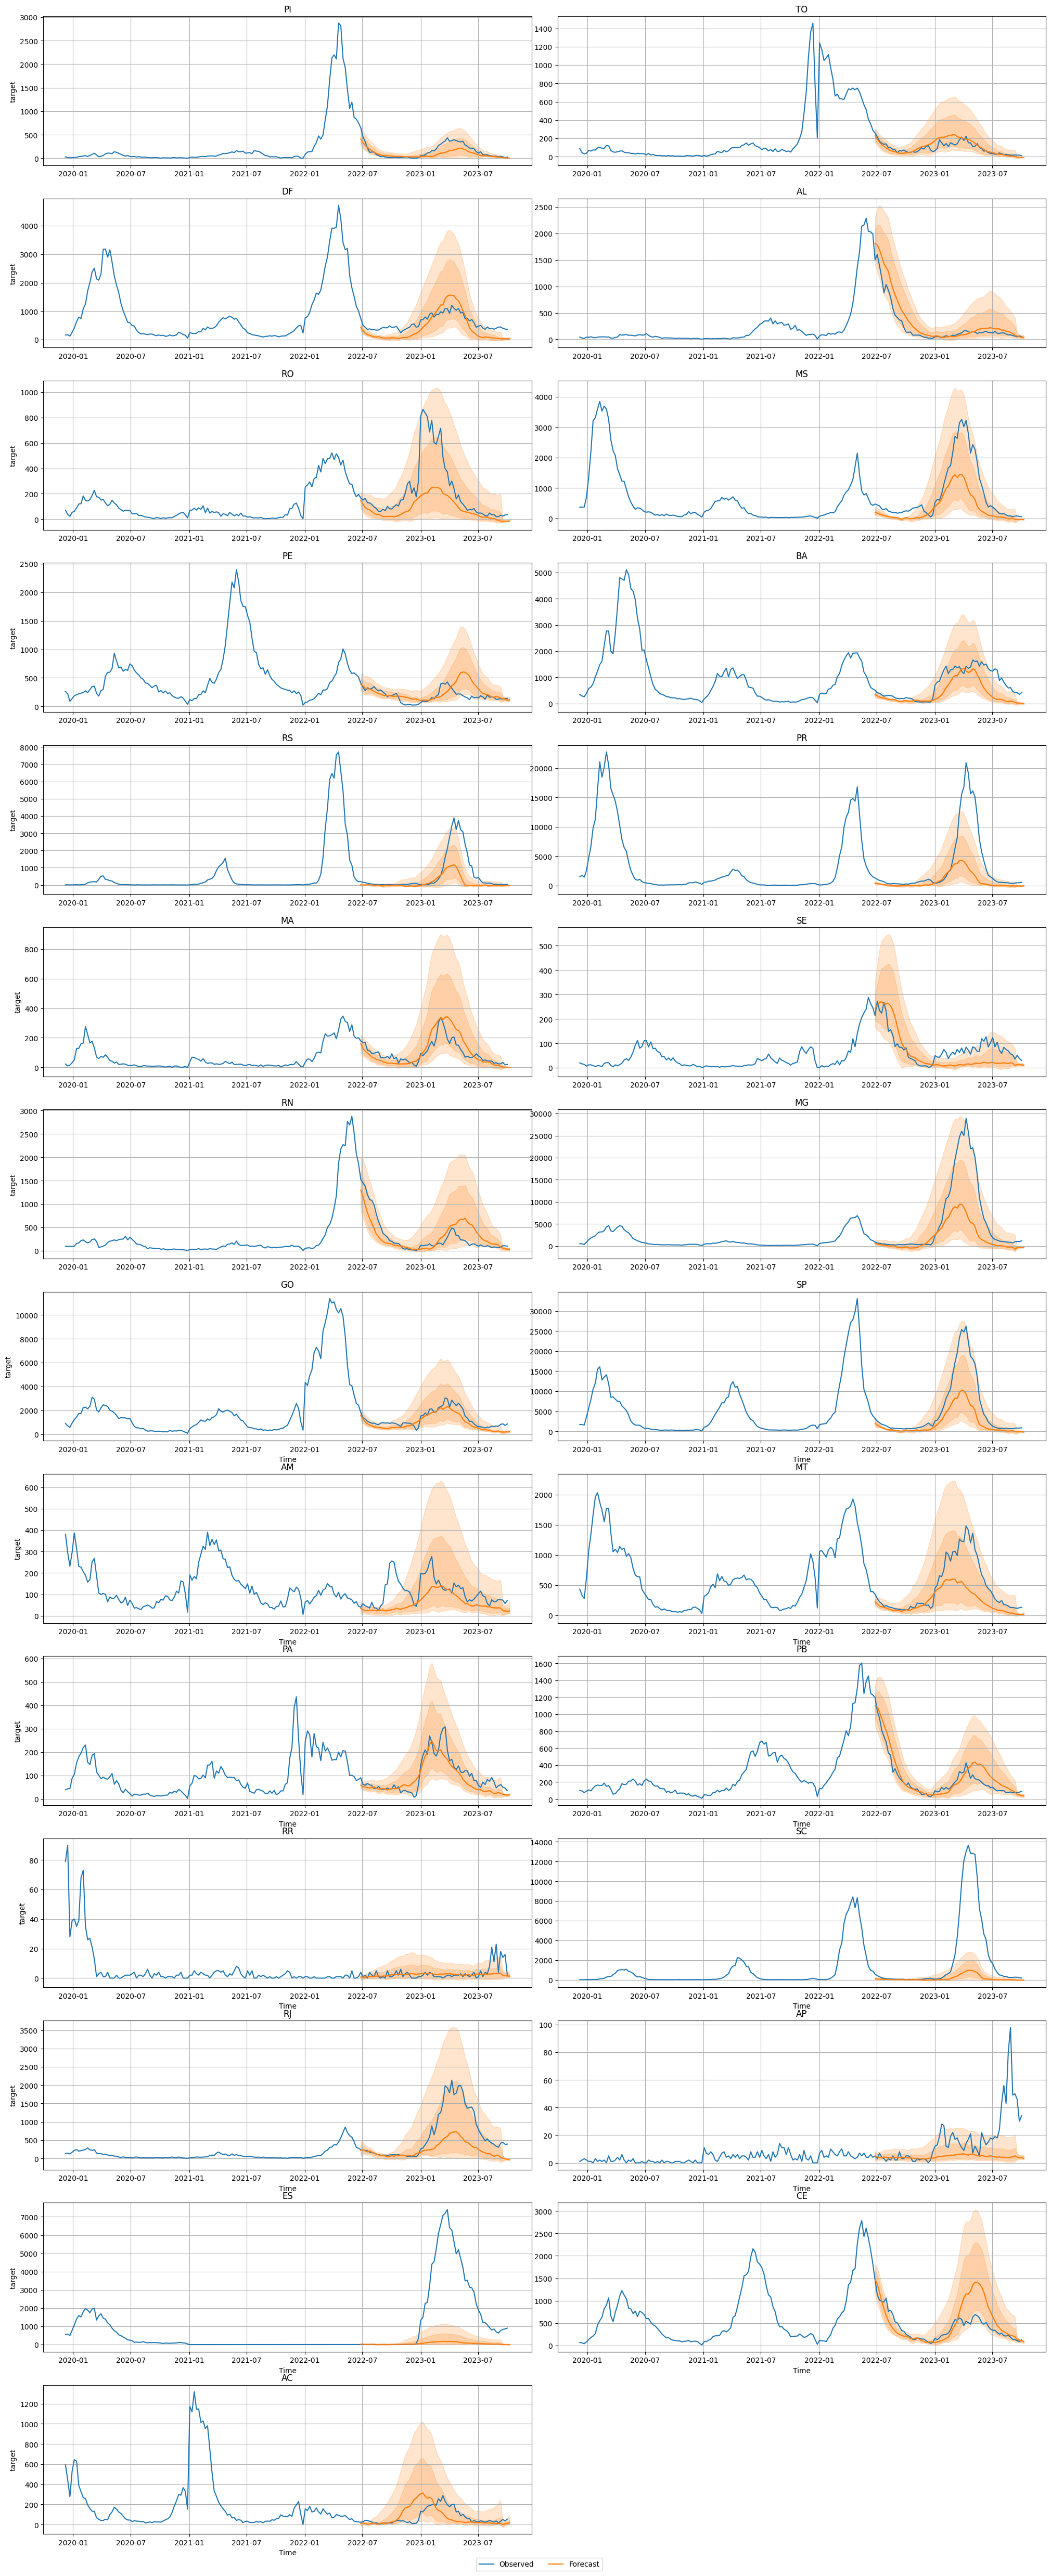

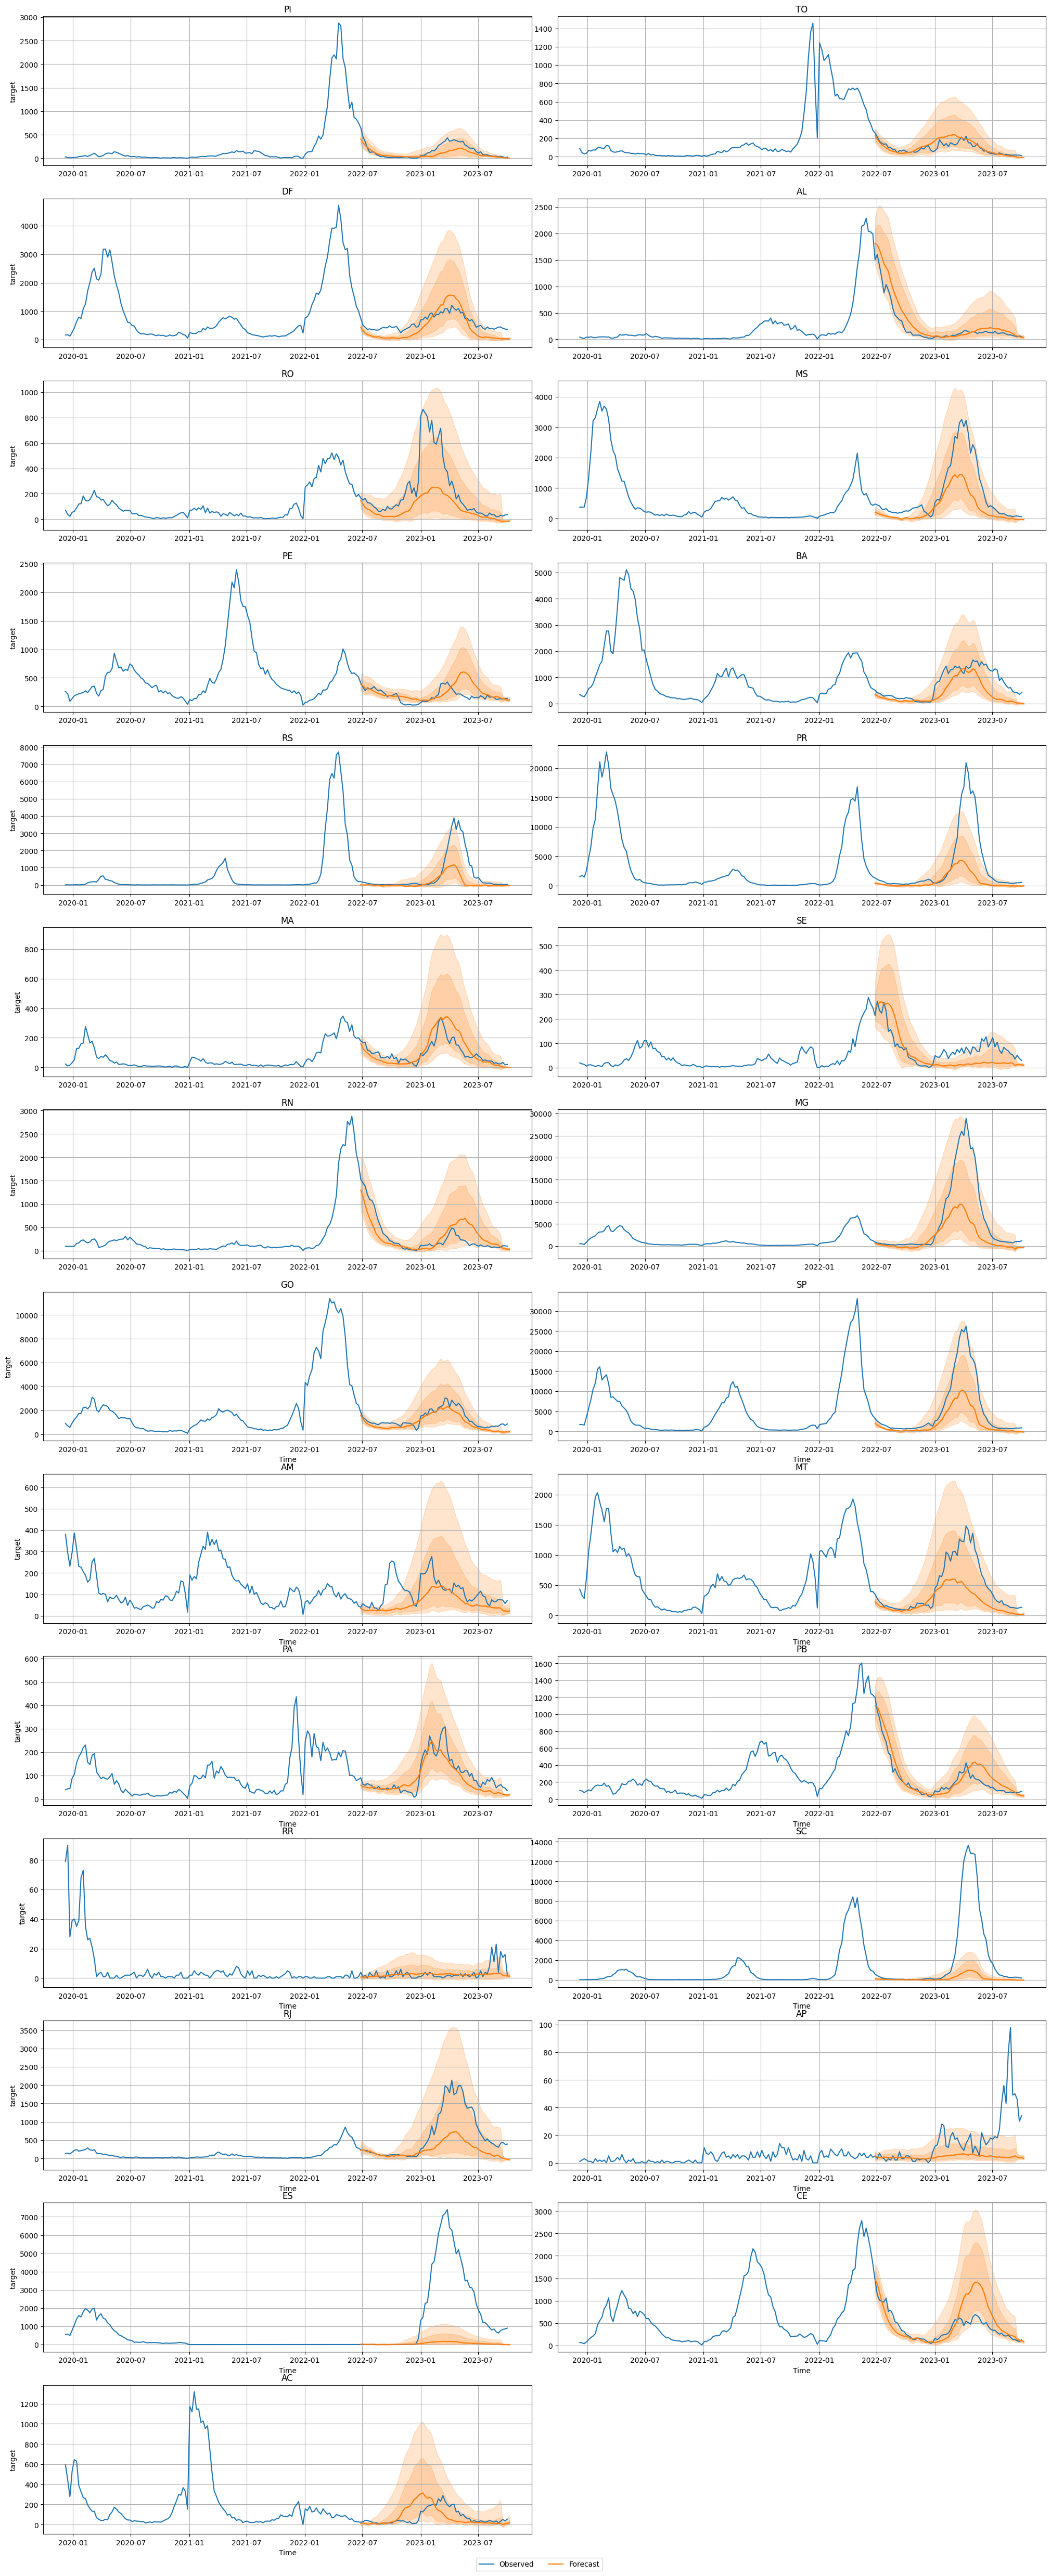

In [15]:
ufs = pd.unique(data['uf'])
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    predictions=predictions,
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=200,
)